In [1]:
import os
#os.chdir("drive/codelab/numbers/detection/")

# Детектор номерных знаков

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from yad2k.models.keras_yolo import (preprocess_true_boxes, yolo_body,
                                     yolo_eval, yolo_head, yolo_loss)
from yad2k.utils.draw_boxes import draw_boxes
import voc_utils as data_parser

Using TensorFlow backend.


In [2]:
%matplotlib inline

Функция получения классов. В нашем случае будет всего один класс - Автомобильные номера

In [3]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

Функция загрузки Якорных ящиков (Anchors boxes)

In [4]:
def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)


Функция подготовки координат местоположений boxов

In [5]:
def process_data(images, boxes=None):
    '''processes the data'''
    images = [PIL.Image.fromarray(i) for i in images]
    orig_size = np.array([images[0].width, images[0].height])
    orig_size = np.expand_dims(orig_size, axis=0)
    print(orig_size)
    # Image preprocessing.
    processed_images = [i.resize((416, 416), PIL.Image.BICUBIC) for i in images]
    processed_images = [np.array(image, dtype=np.float) for image in processed_images]
    processed_images = [image/255. for image in processed_images]

    if boxes is not None:
        # Box preprocessing.
        # Original boxes stored as 1D list of class, x_min, y_min, x_max, y_max.
        # print("boxes", boxes)
        boxes = [box.reshape((-1, 5)) for box in boxes]
        # Get extents as relative x_center, y_center, width, height, class for comparision with
        # find the max number of boxes
        max_boxes = 0
        for boxz in boxes:
            if boxz.shape[0] > max_boxes:
                max_boxes = boxz.shape[0]

        # add zero pad for training
        for i, boxz in enumerate(boxes):
            if boxz.shape[0]  < max_boxes:
                zero_padding = np.zeros( (max_boxes-boxz.shape[0], 5), dtype=np.float32)
                boxes[i] = np.vstack((boxz, zero_padding))

        return np.array(processed_images), np.array(boxes)
    else:
        return np.array(processed_images)

Функция определения масок

In [6]:
def get_detector_mask(boxes, anchors):
    '''
    Precompute detectors_mask and matching_true_boxes for training.
    Detectors mask is 1 for each spatial position in the final conv layer and
    anchor that should be active for the given boxes and 0 otherwise.
    Matching true boxes gives the regression targets for the ground truth box
    that caused a detector to be active or 0 otherwise.
    '''
    detectors_mask = [0 for i in range(len(boxes))]
    matching_true_boxes = [0 for i in range(len(boxes))]
    for i, box in enumerate(boxes):
        detectors_mask[i], matching_true_boxes[i] = preprocess_true_boxes(box, anchors, [416, 416])

    return np.array(detectors_mask), np.array(matching_true_boxes)

Функция создающая нашу модель

In [7]:
def create_model_tiny(anchors, class_names, load_pretrained=True, freeze_body=True):
    '''
    returns the body of the model and the model
    # Params:
    load_pretrained: whether or not to load the pretrained model or initialize all weights
    freeze_body: whether or not to freeze all weights except for the last layer's
    # Returns:
    model_body: YOLO with new output layer
    model: YOLO with custom loss Lambda layer

    '''

    detectors_mask_shape = (13, 13, 5, 1)
    matching_boxes_shape = (13, 13, 5, 5)

    # Create model input layers.
    image_input = Input(shape=(416, 416, 3))
    boxes_input = Input(shape=(None, 5))
    detectors_mask_input = Input(shape=detectors_mask_shape)
    matching_boxes_input = Input(shape=matching_boxes_shape)

    # Create model body.
    yolo_model = load_model(os.path.join('model_data', 'tiny_yolo.h5'))
    topless_yolo = Model(yolo_model.inputs , outputs=yolo_model.layers[-2].output)

    if load_pretrained:
        # Save topless yolo:
        topless_yolo_path = os.path.join('model_data', 'tiny_yolo_topless.h5')
        if not os.path.exists(topless_yolo_path):
            print("CREATING TOPLESS WEIGHTS FILE")
            yolo_path = os.path.join('model_data', 'tiny_yolo.h5')
            model_body = load_model(yolo_path)
            model_body = Model(model_body.inputs, outputs=model_body.layers[-2].output)
            model_body.save_weights(topless_yolo_path, overwrite=True)
        topless_yolo.load_weights(topless_yolo_path)

    if freeze_body:
        for layer in topless_yolo.layers:
            layer.trainable = False
    final_layer = Conv2D(len(anchors)*(5+len(class_names)), (1, 1), activation='linear', name="final_conv2d_layer")(topless_yolo.output)

    model_body = Model(yolo_model.inputs, final_layer)

    # Place model loss on CPU to reduce GPU memory usage.
    with tf.device('/cpu:0'):
        # TODO: Replace Lambda with custom Keras layer for loss.
        model_loss = Lambda(
            yolo_loss,
            output_shape=(1, ),
            name='yolo_loss',
            arguments={'anchors': anchors,
                       'num_classes': len(class_names)})([
                           model_body.output, boxes_input,
                           detectors_mask_input, matching_boxes_input
                       ])

    model = Model(
        [model_body.input, boxes_input, detectors_mask_input,
         matching_boxes_input], model_loss)

    return model_body, model

Функция тренировки нашей модели

In [8]:
def train(model_name, model, class_names, anchors, image_data, boxes, detectors_mask, matching_true_boxes, validation_split=0.1):
    '''
    retrain/fine-tune the model
    logs training with tensorboard
    saves training weights in current directory
    best weights according to val_loss is saved as trained_stage_3_best.h5
    '''
    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


    logging = TensorBoard()

    checkpoint = ModelCheckpoint("model_data/{}_trained_stage_3_best.h5".format(model_name), monitor='val_loss',
                                 save_weights_only=True, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

    model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(image_data)),
              validation_split=validation_split,
              batch_size=2,
              epochs=5,
              callbacks=[logging])
    model.save_weights('model_data/{}_trained_stage_1.h5'.format(model_name))

    model_body, model = create_model_tiny(anchors, class_names, load_pretrained=False, freeze_body=False)

    model.load_weights('model_data/{}_trained_stage_1.h5'.format(model_name))

    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


    model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(image_data)),
              validation_split=0.1,
              batch_size=64,
              epochs=30,
              callbacks=[logging])

    model.save_weights('model_data/{}_trained_stage_2.h5'.format(model_name))

    model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(image_data)),
              validation_split=0.1,
              batch_size=64,
              epochs=30,
              callbacks=[logging, checkpoint, early_stopping])

    model.save_weights('model_data/{}_trained_stage_3.h5'.format(model_name))

Функция отрисовки результата

In [9]:
def draw(model_body, class_names, anchors, image_data,weights_name,  image_set='val',
            out_path="output_images", save_all=True):
    '''
    Draw bounding boxes on image data
    '''
    if image_set == 'train':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data[:int(len(image_data)*.9)]])
    elif image_set == 'val':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data[int(len(image_data)*.9):]])
    elif image_set == 'all':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data])
    else:
        ValueError("draw argument image_set must be 'train', 'val', or 'all'")

    model_body.load_weights(weights_name)

    # Create output variables for prediction.
    yolo_outputs = yolo_head(model_body.output, anchors, len(class_names))
    input_image_shape = K.placeholder(shape=(2, ))
    boxes, scores, classes = yolo_eval(
        yolo_outputs, input_image_shape, score_threshold=0.07, iou_threshold=0.0)

    # Run prediction on overfit image.
    sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.

    if  not os.path.exists(out_path):
        os.makedirs(out_path)
    for i in range(len(image_data)):
        out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                model_body.input: image_data[i],
                input_image_shape: [image_data.shape[2], image_data.shape[3]],
                K.learning_phase(): 0
            })
        print('Found {} boxes for image.'.format(len(out_boxes)))
        print(out_boxes)

        # Plot image with predicted boxes.
        image_with_boxes = draw_boxes(image_data[i][0], out_boxes, out_classes,
                                    class_names, out_scores)
        # Save the image:
        if save_all or (len(out_boxes) > 0):
            image = PIL.Image.fromarray(image_with_boxes)
            image.save(os.path.join(out_path,str(i)+'.png'))

        # To display (pauses the program):
        plt.imshow(image_with_boxes, interpolation='nearest')
        plt.show()

Определим параметры и загрузим изображения

In [ ]:
#Префикс к имени модели
model_name = "tiny"

anchors = get_anchors(os.path.join('in', 'yolo_anchors.txt'))
class_names ,images, boxes, images_paths = data_parser.get_datas(os.path.join('in', 'data/'))
class_names ,images, boxes, images_paths = class_names[:10] ,images[:10], boxes[:10], images_paths[:10]
image_data, boxes = process_data(images, boxes) 
detectors_mask, matching_true_boxes = get_detector_mask(boxes, anchors)

root path:  in/data/
voc
names:  ['image_0000', 'image_0000_gen_1', 'image_0000_gen_2', 'image_0000_gen_3', 'image_0000_gen_4', 'image_0000_gen_5', 'image_0000_gen_6', 'image_0000_gen_7', 'image_0000_gen_8', 'image_0000_gen_9', 'image_0001', 'image_0001_gen_1', 'image_0001_gen_2', 'image_0001_gen_3', 'image_0001_gen_4', 'image_0001_gen_5', 'image_0001_gen_6', 'image_0001_gen_7', 'image_0001_gen_8', 'image_0001_gen_9', 'image_0002', 'image_0002_gen_1', 'image_0002_gen_2', 'image_0002_gen_3', 'image_0002_gen_4', 'image_0002_gen_5', 'image_0002_gen_6', 'image_0002_gen_7', 'image_0002_gen_8', 'image_0002_gen_9', 'image_0003', 'image_0003_gen_1', 'image_0003_gen_2', 'image_0003_gen_3', 'image_0003_gen_4', 'image_0003_gen_5', 'image_0003_gen_6', 'image_0003_gen_7', 'image_0003_gen_8', 'image_0003_gen_9', 'image_0004', 'image_0004_gen_1', 'image_0004_gen_2', 'image_0004_gen_3', 'image_0004_gen_4', 'image_0004_gen_5', 'image_0004_gen_6', 'image_0004_gen_7', 'image_0004_gen_8', 'image_0004_gen_

[[800 600]]


Создадим саму модель

In [ ]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Начнем тренировку

In [ ]:
model_body, model = create_model_tiny(anchors, class_names)
train(
    model_name,
    model,
    class_names,
    anchors,
    image_data,
    boxes,
    detectors_mask,
    matching_true_boxes
)

Сохраним модель

In [13]:
model_body, model = create_model_tiny(anchors, class_names)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/vladimir/anaconda3/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Found 2 boxes for image.
[[ 202.34262085  188.02966309  249.6060791   328.44342041]
 [ 197.16891479   34.37479401  222.30215454   67.22305298]]
car_num 0.95 (188, 202) (328, 250)
car_num 0.31 (34, 197) (67, 222)


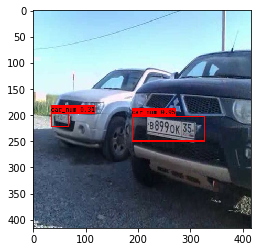

Found 1 boxes for image.
[[ 169.60491943  173.43669128  206.49302673  226.19134521]]
car_num 0.84 (173, 170) (226, 206)


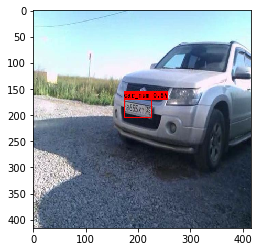

Found 1 boxes for image.
[[ 222.55810547  221.15457153  269.39224243  336.40585327]]
car_num 0.98 (221, 223) (336, 269)


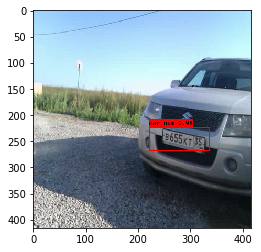

Found 1 boxes for image.
[[ 224.75183105  141.08744812  273.22949219  260.27301025]]
car_num 0.96 (141, 225) (260, 273)


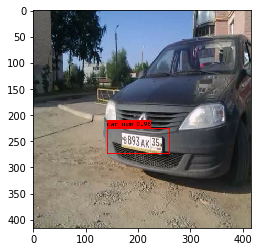

Found 2 boxes for image.
[[ 177.05230713   39.95648193  228.6849823   171.5955658 ]
 [  70.26422882   29.79965782  107.00440979   83.11793518]]
car_num 0.95 (40, 177) (172, 229)
car_num 0.12 (30, 70) (83, 107)


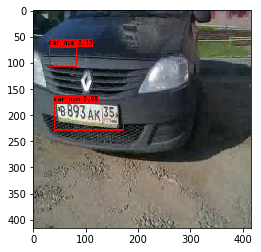

Found 1 boxes for image.
[[ 236.33792114  140.84422302  268.11062622  199.64331055]]
car_num 0.82 (141, 236) (200, 268)


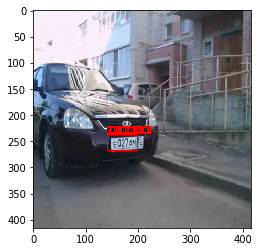

Found 1 boxes for image.
[[ 190.82203674  188.18611145  217.99691772  243.09933472]]
car_num 0.77 (188, 191) (243, 218)


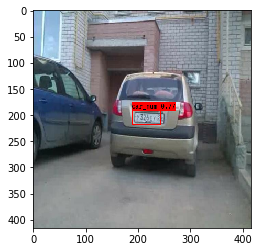

Found 1 boxes for image.
[[ 192.30561829  206.14622498  223.6721344   267.82473755]]
car_num 0.95 (206, 192) (268, 224)


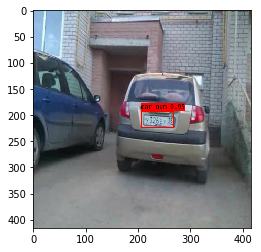

Found 1 boxes for image.
[[ 221.92401123  118.82051086  261.20825195  184.63232422]]
car_num 0.92 (119, 222) (185, 261)


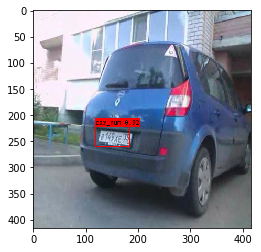

Found 1 boxes for image.
[[ 191.97093201  195.78417969  237.62129211  327.38400269]]
car_num 0.99 (196, 192) (327, 238)


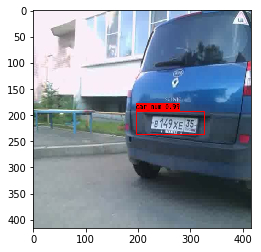

Found 1 boxes for image.
[[ 246.11184692  107.33105469  277.83618164  163.32363892]]
car_num 0.93 (107, 246) (163, 278)


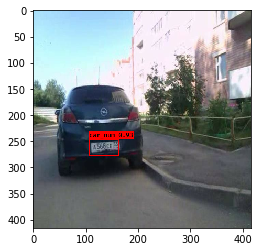

Found 1 boxes for image.
[[ 252.16326904  111.04647064  283.88781738  169.36087036]]
car_num 0.96 (111, 252) (169, 284)


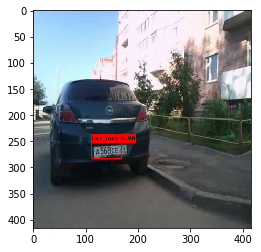

Found 1 boxes for image.
[[ 255.01956177  141.28366089  297.52081299  250.48443604]]
car_num 0.98 (141, 255) (250, 298)


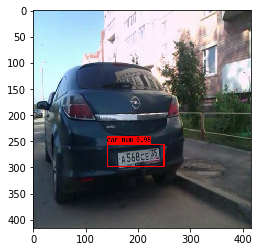

Found 1 boxes for image.
[[ 189.43132019  113.15044403  219.50872803  164.92251587]]
car_num 0.72 (113, 189) (165, 220)


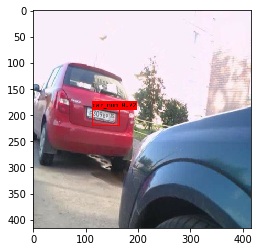

Found 1 boxes for image.
[[ 183.62162781  110.62982941  215.78311157  165.55932617]]
car_num 0.81 (111, 184) (166, 216)


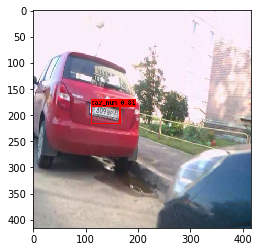

Found 1 boxes for image.
[[ 267.09509277  191.61534119  324.41937256  333.58465576]]
car_num 0.72 (192, 267) (334, 324)


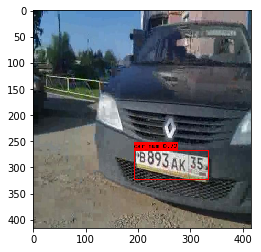

Found 1 boxes for image.
[[ 182.50668335  103.82151794  217.8165741   167.12409973]]
car_num 0.96 (104, 183) (167, 218)


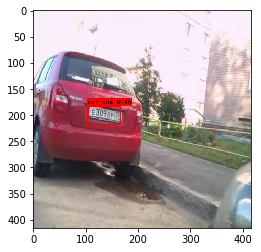

Found 1 boxes for image.
[[ 161.53636169  104.10007477  211.70698547  220.50396729]]
car_num 0.97 (104, 162) (221, 212)


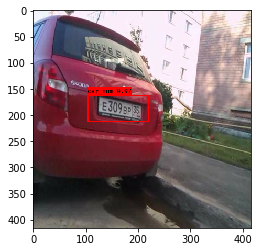

Found 1 boxes for image.
[[ 222.10453796  180.18328857  253.02571106  229.98907471]]
car_num 0.85 (180, 222) (230, 253)


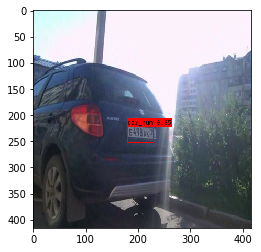

Found 1 boxes for image.
[[ 196.1242218    33.12420654  222.32026672   74.19937897]]
car_num 0.66 (33, 196) (74, 222)


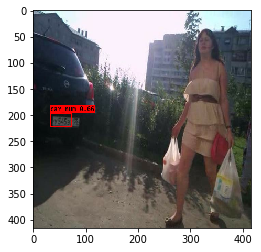

Found 1 boxes for image.
[[ 226.14561462  185.49121094  257.51177979  224.97213745]]
car_num 0.21 (185, 226) (225, 258)


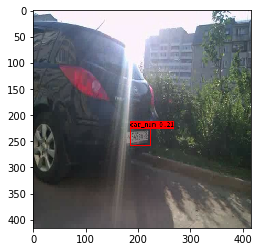

Found 1 boxes for image.
[[ 236.504776     45.46664047  262.83007812   97.90457916]]
car_num 0.91 (45, 237) (98, 263)


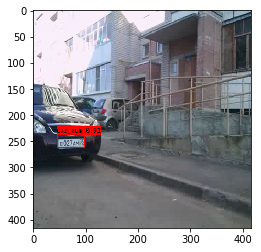

Found 1 boxes for image.
[[ 216.35403442   76.11250305  244.59118652  128.79632568]]
car_num 0.96 (76, 216) (129, 245)


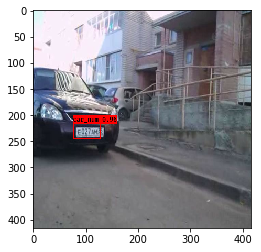

Found 1 boxes for image.
[[ 253.45817566  294.77706909  336.5869751   380.91949463]]
car_num 0.22 (295, 253) (381, 337)


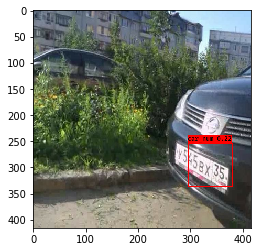

Found 1 boxes for image.
[[ 224.07270813  177.36349487  271.9465332   299.4239502 ]]
car_num 0.98 (177, 224) (299, 272)


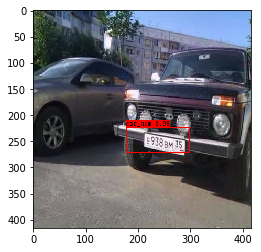

Found 1 boxes for image.
[[ 211.35766602  155.41819763  260.81170654  265.34487915]]
car_num 0.92 (155, 211) (265, 261)


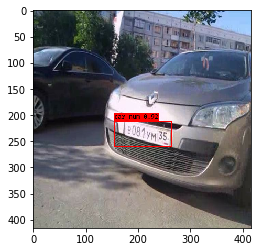

Found 1 boxes for image.
[[ 221.37168884   60.99043274  272.38208008  175.89154053]]
car_num 0.95 (61, 221) (176, 272)


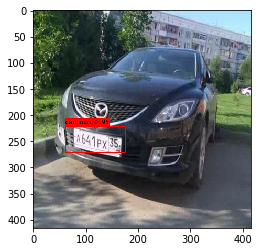

Found 1 boxes for image.
[[ 286.70794678   99.85958862  341.80432129  232.23193359]]
car_num 0.94 (100, 287) (232, 342)


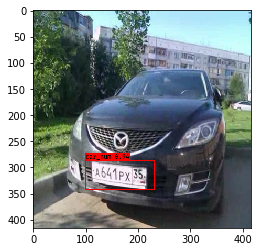

Found 2 boxes for image.
[[ 194.2830658    53.85161972  228.32391357  112.32611847]
 [  51.27186584  258.29821777   94.60926056  394.58331299]]
car_num 0.94 (54, 194) (112, 228)
car_num 0.09 (258, 51) (395, 95)


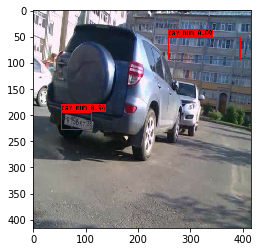

Found 2 boxes for image.
[[ 216.68287659   83.13576508  253.3946991   147.99021912]
 [  55.5150032   264.02236938   96.92398834  397.91448975]]
car_num 0.93 (83, 217) (148, 253)
car_num 0.10 (264, 56) (398, 97)


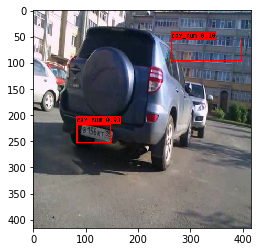

In [16]:
draw(model_body,
    class_names,
    anchors,
    image_data,
    weights_name='model_data/{}_trained_stage_3_best.h5'.format(model_name),
    image_set='val', # assumes training/validation split is 0.9
    save_all=True)

Сохраним модель с весами

In [17]:
model_body.save(os.path.join('model_data', '{}_yolo_finish.h5'.format(model_name)))

## Функция для выгрузки в Андроид

In [21]:
def save_to_android(input_name, output_name, model_name, weights_name):
    K.set_learning_phase(0)

    model = load_model(os.path.join('model_data', model_name), compile=False)
    model.load_weights(os.path.join('model_data', weights_name))

    sess = K.get_session()

    export_base_path = 'tf-exports'
    if not os.path.exists(export_base_path):
        os.makedirs(export_base_path)
    
    protobuf_path = os.path.join(export_base_path, 'yolo-tiny-v1.pbtxt')
    checkpoint_path = os.path.join(export_base_path, 'yolo-tiny-v1.ckpt')

    tf.train.write_graph(sess.graph_def, '.', protobuf_path)

    saver = tf.train.Saver()
    saver.save(sess, save_path = checkpoint_path)

Сохраним данные о модели в protobuf для последующей выгрузки в Андроид

In [23]:
input_name = 'input_1' 
output_name = 'final_conv2d_layer/BiasAdd' 
save_to_android(input_name, 
                output_name,
                model_name='{}_yolo_finish.h5'.format(model_name), 
                weights_name='{}_trained_stage_3_best.h5'.format(model_name))

## Функция нарезающая номерные знаки, пригодится для подготовки данных для распознания

In [24]:
def crop_and_resize(index, image, boxes, box_classes, croped_output_path):
    image = Image.fromarray(np.floor(image * 255 + 0.5).astype('uint8'))

    for i, c in list(enumerate(box_classes)):
        box = boxes[i]

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print("croped and resized:",os.path.join(croped_output_path, str(index) + '.png'))

        image_crop = image.crop([left + i, top + i, right - i, bottom - i])
        image_resize = image_crop.resize((416,416), resample=Image.BICUBIC)
        image_resize.save(os.path.join(croped_output_path, str(index) + '.png'))
        

In [25]:
def crop_and_save_numbers_licence(model, class_names, anchors, image_data, output_path="output_images", save_all=True, croped_output_path=None):
    '''
    Draw bounding boxes on image data
    '''
    image_data = np.array([np.expand_dims(image, axis=0)
                           for image in image_data])
    print("model.output", model.output)
    # Tensor("yolo_loss/mul_13:0", shape=(), dtype=float32, device=/device:CPU:0)
    # Create output variables for prediction.
    yolo_outputs = yolo_head(model.output, anchors, len(class_names))
    input_image_shape = K.placeholder(shape=(2, ))
    boxes, scores, classes = yolo_eval(
        yolo_outputs, input_image_shape, score_threshold=0.07, iou_threshold=0.0)

    # Run prediction on overfit image.
    sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.

    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for i in range(len(image_data)):
        out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                model.input: image_data[i],
                input_image_shape: [image_data.shape[2], image_data.shape[3]],
                K.learning_phase(): 0
            })
        print('Found {} boxes for image.'.format(len(out_boxes)))
        print(out_boxes)
        print("croped_output_path:",croped_output_path)

        # Plot image with predicted boxes.
        image_with_boxes = draw_boxes(image_data[i][0], out_boxes, out_classes,
                                      class_names, out_scores)
        # Save the image:
        if save_all or (len(out_boxes) > 0):
            image = Image.fromarray(image_with_boxes)
            image.save(os.path.join(output_path, str(i) + '.png'))

        if croped_output_path != None :
            crop_and_resize(i, image_data[i][0], out_boxes, out_classes, croped_output_path)
        # To display (pauses the program):
        # plt.imshow(image_with_boxes, interpolation='nearest')
        # plt.show()